 # Feature Importance 

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set default font to DejaVu Sans
rcParams['font.sans-serif'] = ['DejaVu Sans']

In [2]:
import pandas as pd 
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LassoCV, Ridge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import friedmanchisquare
from sklearn.model_selection import KFold

# Reading all the data

In [4]:
df_all=pd.read_csv('data_compiled.csv')
df_all.drop(['Unnamed: 0'],axis=1, inplace=True)
df_all=df_all.dropna()
# Extract time components and create sine/cosine transformations
df_all['Time'] = pd.to_datetime(df_all['Time'])
df_all['hour'] = df_all['Time'].dt.hour
df_all['minute'] = df_all['Time'].dt.minute
df_all['second'] = df_all['Time'].dt.second

# Apply sine and cosine transformations
df_all['sin_hour'] = np.sin(2 * np.pi * df_all['hour'] / 24)
df_all['cos_hour'] = np.cos(2 * np.pi * df_all['hour'] / 24)
df_all['sin_minute'] = np.sin(2 * np.pi * df_all['minute'] / 60)
df_all['cos_minute'] = np.cos(2 * np.pi * df_all['minute'] / 60)
df_all['sin_second'] = np.sin(2 * np.pi * df_all['second'] / 60)
df_all['cos_second'] = np.cos(2 * np.pi * df_all['second'] / 60)
df_all.drop(['Date', 'Time'], axis=1, inplace=True)

In [5]:
df_all

,IG,HR_Mean,HR_Max,HR_Std,HR_Skew,HR_Q1G,HR_Q3G,EDA_Mean,EDA_Max,EDA_Std,...,stage_5_count_percent_diff_from_recommended,hour,minute,second,sin_hour,cos_hour,sin_minute,cos_minute,sin_second,cos_second
0,97.0,73.225681,73.57,0.234825,-0.862047,73.108174,73.313689,0.301333,0.334533,0.015065,...,-14.690476,0,3,24,0.000000,1.000000,0.309017,0.951057,0.587785,-0.809017
1,95.0,72.758239,73.57,0.351658,0.620606,72.608911,72.921836,0.359451,0.394727,0.018376,...,-14.690476,0,8,23,0.000000,1.000000,0.743145,0.669131,0.669131,-0.743145
2,92.0,73.699934,75.07,0.628637,-0.038853,73.416714,73.968872,0.423380,0.458762,0.018286,...,-14.690476,0,13,24,0.000000,1.000000,0.978148,0.207912,0.587785,-0.809017
3,89.0,73.565316,77.47,2.043241,0.121869,72.647048,74.517301,0.481480,1.456508,0.069042,...,-14.690476,0,18,24,0.000000,1.000000,0.951057,-0.309017,0.587785,-0.809017
4,90.0,75.144385,80.30,2.978029,0.467569,73.879337,76.672485,1.854490,5.904090,1.911557,...,-14.690476,0,23,24,0.000000,1.000000,0.669131,-0.743145,0.587785,-0.809017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20364,174.0,83.044585,87.05,1.797977,0.482883,82.291102,83.831879,0.570997,0.596047,0.004867,...,-21.725329,8,53,25,0.866025,-0.500000,-0.669131,0.743145,0.500000,-0.866025
20365,181.0,85.898538,88.55,1.808236,-0.842159,84.978402,86.595798,0.530921,0.566582,0.004439,...,-21.725329,9,13,25,0.707107,-0.707107,0.978148,0.207912,0.500000,-0.866025
20366,177.0,82.445449,86.57,2.433794,-0.729108,81.244232,83.365709,0.515155,0.538398,0.005217,...,-21.725329,9,18,25,0.707107,-0.707107,0.951057,-0.309017,0.500000,-0.866025
20367,166.0,86.173621,87.45,0.689601,-1.170720,85.873365,86.427853,0.509617,0.516619,0.003153,...,-21.725329,9,28,24,0.707107,-0.707107,0.207912,-0.978148,0.587785,-0.809017


In [6]:
other_features=['HR_Mean', 'HR_Max', 'HR_Std', 'HR_Skew', 'HR_Q1G',
       'HR_Q3G', 'EDA_Mean', 'EDA_Max', 'EDA_Std', 'EDA_Skew', 'EDA_Q1G',
       'EDA_Q3G', 'TEMP_Mean', 'TEMP_Max', 'TEMP_Std', 'TEMP_Skew', 'TEMP_Q1G',
       'TEMP_Q3G', 'ACC_Mean', 'ACC_Max', 'ACC_Std', 'ACC_Skew', 'ACC_Q1G',
       'ACC_Q3G', 'BVP_Mean', 'BVP_Max', 'BVP_Std', 'BVP_Skew', 'BVP_Q1G',
       'BVP_Q3G', 'PeakEDA', 'maxHRV', 'minHRV', 'medianHRV', 'SDNN', 'NN50',
       'pNN50', 'RMSSD', 'calories2hr', 'protien2hr', 'sugar2hr', 'carbs2hr',
       'protien8hr', 'sugar8hr', 'carbs8hr', 'calories24hr', 'protien24hr',
       'sugar24hr', 'carbs24hr', 'Eat', 'Eatcnt2hr', 'Eatcnt8hr', 'Eatcnt24hr',
       'Eatmean2hr', 'Eatmean8hr', 'Eatmean24hr', 'Minfrommid', 'Hourfrommid',
       'EDA_Min', 'calories8hr', 'TEMP_Min', 'BVP_Min', 'ACC_Min', 'HR_Min',
       'HR_Mean_Historical', 'HR_Std_Historical', 'ACC_Mean_Historical',
       'ACC_Std_Historical', 'Activity_Bouts', 'Activity24',
       'Activity1h']

In [7]:
all_sleep_features=['total_sleep_time','percent_time_asleep','waso','sleep_onset_latency',
                    'number_wake_bouts', 'stage_0_count','stage_2_count','stage_3_count',
                    'stage_5_count','stage_0_count_log','total_sleep_time_log',
                    'percent_time_asleep_log','stage_0_count_boxcox','stage_0_count_yeojohnson',
                    'stage_0_count_rank','stage_0_count_standardized','total_sleep_timelog',
                    'percent_time_asleeplog','wasolog','sleep_onset_latencylog','number_wake_boutslog',
                    'stage_0_countlog','stage_1_countlog','stage_2_countlog','stage_3_countlog','stage_5_countlog',
                    'total_sleep_time_boxcox','total_sleep_time_yeojohnson','total_sleep_time_rank','percent_time_asleep_boxcox',
                    'percent_time_asleep_yeojohnson','percent_time_asleep_rank','waso_boxcox','waso_yeojohnson','waso_rank',
                    'sleep_onset_latency_yeojohnson','sleep_onset_latency_rank','number_wake_bouts_boxcox','number_wake_bouts_yeojohnson',
                    'number_wake_bouts_rank','stage_1_count_boxcox','stage_1_count_yeojohnson','stage_1_count_rank','stage_2_count_boxcox',
                    'stage_2_count_yeojohnson','stage_2_count_rank','stage_3_count_boxcox','stage_3_count_yeojohnson','stage_3_count_rank',
                    'stage_5_count_boxcox','stage_5_count_yeojohnson','stage_5_count_rank','stage_0_count_percent','stage_1_count_percent',
                    'stage_2_count_percent','stage_3_count_percent','stage_5_count_percent','stage_1_count_percent_diff_from_recommended',
                    'stage_2_count_percent_diff_from_recommended','stage_3_count_percent_diff_from_recommended',
                    'stage_5_count_percent_diff_from_recommended']

In [8]:
transformed_sleep_features=['waso','number_wake_bouts','stage_0_count_log','total_sleep_time_log',
                    'percent_time_asleep_log', 'total_sleep_timelog', 'percent_time_asleeplog','total_sleep_time_rank',
                    'percent_time_asleep_rank','sleep_onset_latency_rank','stage_1_count_rank','stage_3_count_yeojohnson',
                    'stage_2_count_rank','stage_3_count_rank','stage_5_count_yeojohnson','stage_0_count_percent','stage_1_count_percent',
                    'stage_2_count_percent','stage_3_count_percent','stage_5_count_percent','stage_1_count_percent_diff_from_recommended',
                    'stage_2_count_percent_diff_from_recommended','stage_3_count_percent_diff_from_recommended',
                    'stage_5_count_percent_diff_from_recommended']

In [9]:
unmodified_sleep_features= ['total_sleep_time','percent_time_asleep','waso','sleep_onset_latency',
                    'number_wake_bouts', 'stage_0_count','stage_2_count','stage_3_count',
                    'stage_5_count']

In [10]:
feature_sets = {
    'other_features': other_features,
    'other_features + unmodified_sleep_features': other_features + unmodified_sleep_features,
    'other_features + transformed_sleep_features': other_features + transformed_sleep_features,
    'other_features + all_sleep_features': other_features + all_sleep_features
}

In [11]:
# Define feature categories
feature_categories = {
    'HR_features': ['HR_Mean', 'HR_Max', 'HR_Std', 'HR_Skew', 'HR_Q1G', 'HR_Q3G', 'HR_Min', 'HR_Mean_Historical', 'HR_Std_Historical'],
    'EDA_features': ['EDA_Mean', 'EDA_Max', 'EDA_Std', 'EDA_Skew', 'EDA_Q1G', 'EDA_Q3G', 'EDA_Min', 'PeakEDA'],
    'Temperature_features': ['TEMP_Mean', 'TEMP_Max', 'TEMP_Std', 'TEMP_Skew', 'TEMP_Q1G', 'TEMP_Q3G', 'TEMP_Min'],
    'Accelerometer_features': ['ACC_Mean', 'ACC_Max', 'ACC_Std', 'ACC_Skew', 'ACC_Q1G', 
                               'ACC_Q3G', 'ACC_Min', 'ACC_Mean_Historical', 'ACC_Std_Historical',
                              'Activity_Bouts', 'Activity24', 'Activity1h'],
    'BVP_features': ['BVP_Mean', 'BVP_Max', 'BVP_Std', 'BVP_Skew', 'BVP_Q1G', 'BVP_Q3G', 'BVP_Min'],
    'ANS_features': ['maxHRV', 'minHRV', 'medianHRV', 'SDNN', 'NN50', 'pNN50', 'RMSSD'],
    'Sleep_features': ['total_sleep_time', 'percent_time_asleep', 'waso', 'sleep_onset_latency', 'number_wake_bouts', 'stage_0_count', 'stage_1_count', 'stage_2_count', 'stage_3_count', 'stage_5_count', 
                       'stage_0_count_log', 'total_sleep_time_log', 'percent_time_asleep_log', 'stage_0_count_boxcox', 'stage_0_count_yeojohnson', 'stage_0_count_rank', 'stage_0_count_standardized', 
                       'total_sleep_timelog', 'percent_time_asleeplog', 'wasolog', 'sleep_onset_latencylog', 'number_wake_boutslog', 'stage_0_countlog', 'stage_1_countlog', 'stage_2_countlog', 'stage_3_countlog', 
                       'stage_5_countlog', 'total_sleep_time_boxcox', 'total_sleep_time_yeojohnson', 'total_sleep_time_rank', 'percent_time_asleep_boxcox', 'percent_time_asleep_yeojohnson', 'percent_time_asleep_rank', 
                       'waso_boxcox', 'waso_yeojohnson', 'waso_rank', 'sleep_onset_latency_yeojohnson', 'sleep_onset_latency_rank', 'number_wake_bouts_boxcox', 'number_wake_bouts_yeojohnson', 'number_wake_bouts_rank', 
                       'stage_1_count_boxcox', 'stage_1_count_yeojohnson', 'stage_1_count_rank', 'stage_2_count_boxcox', 'stage_2_count_yeojohnson', 'stage_2_count_rank', 'stage_3_count_boxcox', 'stage_3_count_yeojohnson', 
                       'stage_3_count_rank', 'stage_5_count_boxcox', 'stage_5_count_yeojohnson', 'stage_5_count_rank', 'stage_0_count_percent', 'stage_1_count_percent', 'stage_2_count_percent', 'stage_3_count_percent', 
                       'stage_5_count_percent', 'stage_1_count_percent_diff_from_recommended', 'stage_2_count_percent_diff_from_recommended', 'stage_3_count_percent_diff_from_recommended', 'stage_5_count_percent_diff_from_recommended'],
    'Nutritional_intake_features': ['calories2hr', 'protien2hr', 'sugar2hr', 'carbs2hr', 'protien8hr', 'sugar8hr', 'carbs8hr', 'calories24hr', 'protien24hr', 'sugar24hr', 'carbs24hr', 'Eat', 'Eatcnt2hr', 'Eatcnt8hr', 
                                    'Eatcnt24hr', 'Eatmean2hr', 'Eatmean8hr', 'Eatmean24hr'],
    'time_features': ['Minfrommid', 'Hourfrommid',  'HbA1c','hour', 'minute','second','sin_hour','cos_hour',
                      'sin_minute','cos_minute','sin_second','cos_second'],
    'individuali_features':['2.0','3.0','4.0','5.0','6.0','8.0','9.0','10.0','11.0','12.0','13.0','14.0','15.0','16.0','FEMALE', 'MALE'],
}


In [14]:
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import shap
from tqdm import tqdm

In [15]:
X = df_all.drop(['glucose_level', 'IG', 'Mean'], axis=1)
y = df_all['IG']

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameter space
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
    
    # Create the model with the suggested hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=30,
        n_jobs=-1
    )
    
    # Perform cross-validation
    cv_score = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error').mean()
    
    return -cv_score

In [ ]:
# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-08-09 10:39:44,197] A new study created in memory with name: no-name-492da12b-08a0-45f6-9fa4-0cfb1db4737b
/dev/shm/jobs/49007665/ipykernel_41116/1832959860.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from tqdm import tqdm


# Define the features and target
X = df_all.drop(['glucose_level','IG','Mean'], axis=1)
y = df_all['IG']


# Prepare to store results
importances_list = []
shap_values_list = []
rmse_list = []


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)
rf = DecisionTreeRegressor()
# Run the regression 10 times with tqdm progress bar
for i in tqdm(range(10), desc="Running regressions"):
    # Split the data
    
    
    print('Training the model')
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_list.append(rmse)
    print(f'RMSE for run {i+1}: {rmse}')
    
    
    
    print(' Storing feature importances')
    importances_list.append(rf.feature_importances_)
    
    print('Generating SHAP values')
    explainer = shap.Explainer(rf)
    shap_values = explainer.shap_values(X_test)
    shap_values_list.append(shap_values)
    
    print(' Plotting SHAP values')
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title(f'SHAP Summary Plot Run {i+1}')
    plt.savefig(f'shap_values/shap_summary_plot_run_{i+1}.png')
    plt.close()

# Calculate mean and std for feature importances
importances_array = np.array(importances_list)
importances_mean = np.mean(importances_array, axis=0)
importances_std = np.std(importances_array, axis=0)

# Create a DataFrame for feature importances
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean Importance': importances_mean,
    'Std Importance': importances_std
})
importances_df.to_csv('feature_importances.csv')

# Plot mean feature importances with error bars
plt.figure(figsize=(14, 8))
sns.barplot(x='Mean Importance', y='Feature', data=importances_df.sort_values(by='Mean Importance', ascending=False))
plt.title('Feature Importances with Mean and Standard Deviation')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importances.png')
plt.show()

# Club features into categories for analysis
for category, features in tqdm(feature_categories.items(), desc="Generating SHAP summary plots"):
    category_shap_values = np.sum([shap_values_list[i][:, [X.columns.get_loc(feature) for feature in features if feature in X.columns]] for i in range(10)], axis=0)
    
    shap.summary_plot(category_shap_values, X_test[features], show=False)
    plt.title(f'SHAP Summary Plot for {category}')
    plt.savefig(f'shap_values/shap_summary_plot_{category}.svg')
    plt.close()

print("Feature importances and SHAP values plotted and saved.")

Running regressions:   0%|          | 0/10 [00:00<?, ?it/s]

Training the model
RMSE for run 1: 13.383117840669822
 Storing feature importances
Generating SHAP values
 Plotting SHAP values


Running regressions:  10%|█         | 1/10 [01:09<10:27, 69.70s/it]

Training the model
RMSE for run 2: 13.403337776800543
 Storing feature importances
Generating SHAP values
 Plotting SHAP values


Running regressions:  20%|██        | 2/10 [02:18<09:12, 69.06s/it]

Training the model
RMSE for run 3: 13.468382838819506
 Storing feature importances
Generating SHAP values
 Plotting SHAP values


Running regressions:  30%|███       | 3/10 [03:26<07:59, 68.52s/it]

Training the model
RMSE for run 4: 13.357633701311366
 Storing feature importances
Generating SHAP values
 Plotting SHAP values


Running regressions:  40%|████      | 4/10 [04:36<06:55, 69.30s/it]

Training the model
RMSE for run 5: 13.631079425493294
 Storing feature importances
Generating SHAP values
 Plotting SHAP values


Running regressions:  50%|█████     | 5/10 [05:47<05:48, 69.79s/it]

Training the model


In [36]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt

Running Classifications:   0%|          | 0/10 [00:00<?, ?it/s]

Training the model
Accuracy for run 1: 0.7270142180094786
 Storing feature importances
Generating SHAP values
 Plotting SHAP values


Running Classifications:  10%|█         | 1/10 [00:02<00:26,  2.93s/it]

Training the model
Accuracy for run 2: 0.737914691943128
 Storing feature importances
Generating SHAP values
 Plotting SHAP values


Running Classifications:  20%|██        | 2/10 [00:05<00:23,  2.90s/it]

Training the model
Accuracy for run 3: 0.7246445497630332
 Storing feature importances
Generating SHAP values
 Plotting SHAP values


Running Classifications:  30%|███       | 3/10 [00:08<00:20,  2.89s/it]

Training the model
Accuracy for run 4: 0.7360189573459716
 Storing feature importances
Generating SHAP values
 Plotting SHAP values


Running Classifications:  40%|████      | 4/10 [00:11<00:17,  2.89s/it]

Training the model
Accuracy for run 5: 0.738388625592417
 Storing feature importances
Generating SHAP values
 Plotting SHAP values


Running Classifications:  50%|█████     | 5/10 [00:15<00:15,  3.10s/it]

Training the model
Accuracy for run 6: 0.7341232227488151
 Storing feature importances
Generating SHAP values
 Plotting SHAP values


Running Classifications:  60%|██████    | 6/10 [00:18<00:12,  3.09s/it]

Training the model
Accuracy for run 7: 0.7312796208530805
 Storing feature importances
Generating SHAP values
 Plotting SHAP values


Running Classifications:  70%|███████   | 7/10 [00:21<00:09,  3.03s/it]

Training the model
Accuracy for run 8: 0.7412322274881517
 Storing feature importances
Generating SHAP values
 Plotting SHAP values


Running Classifications:  80%|████████  | 8/10 [00:23<00:05,  2.98s/it]

Training the model
Accuracy for run 9: 0.7270142180094786
 Storing feature importances
Generating SHAP values
 Plotting SHAP values


Running Classifications:  90%|█████████ | 9/10 [00:26<00:02,  2.97s/it]

Training the model
Accuracy for run 10: 0.7355450236966825
 Storing feature importances
Generating SHAP values
 Plotting SHAP values


Running Classifications: 100%|██████████| 10/10 [00:29<00:00,  2.98s/it]


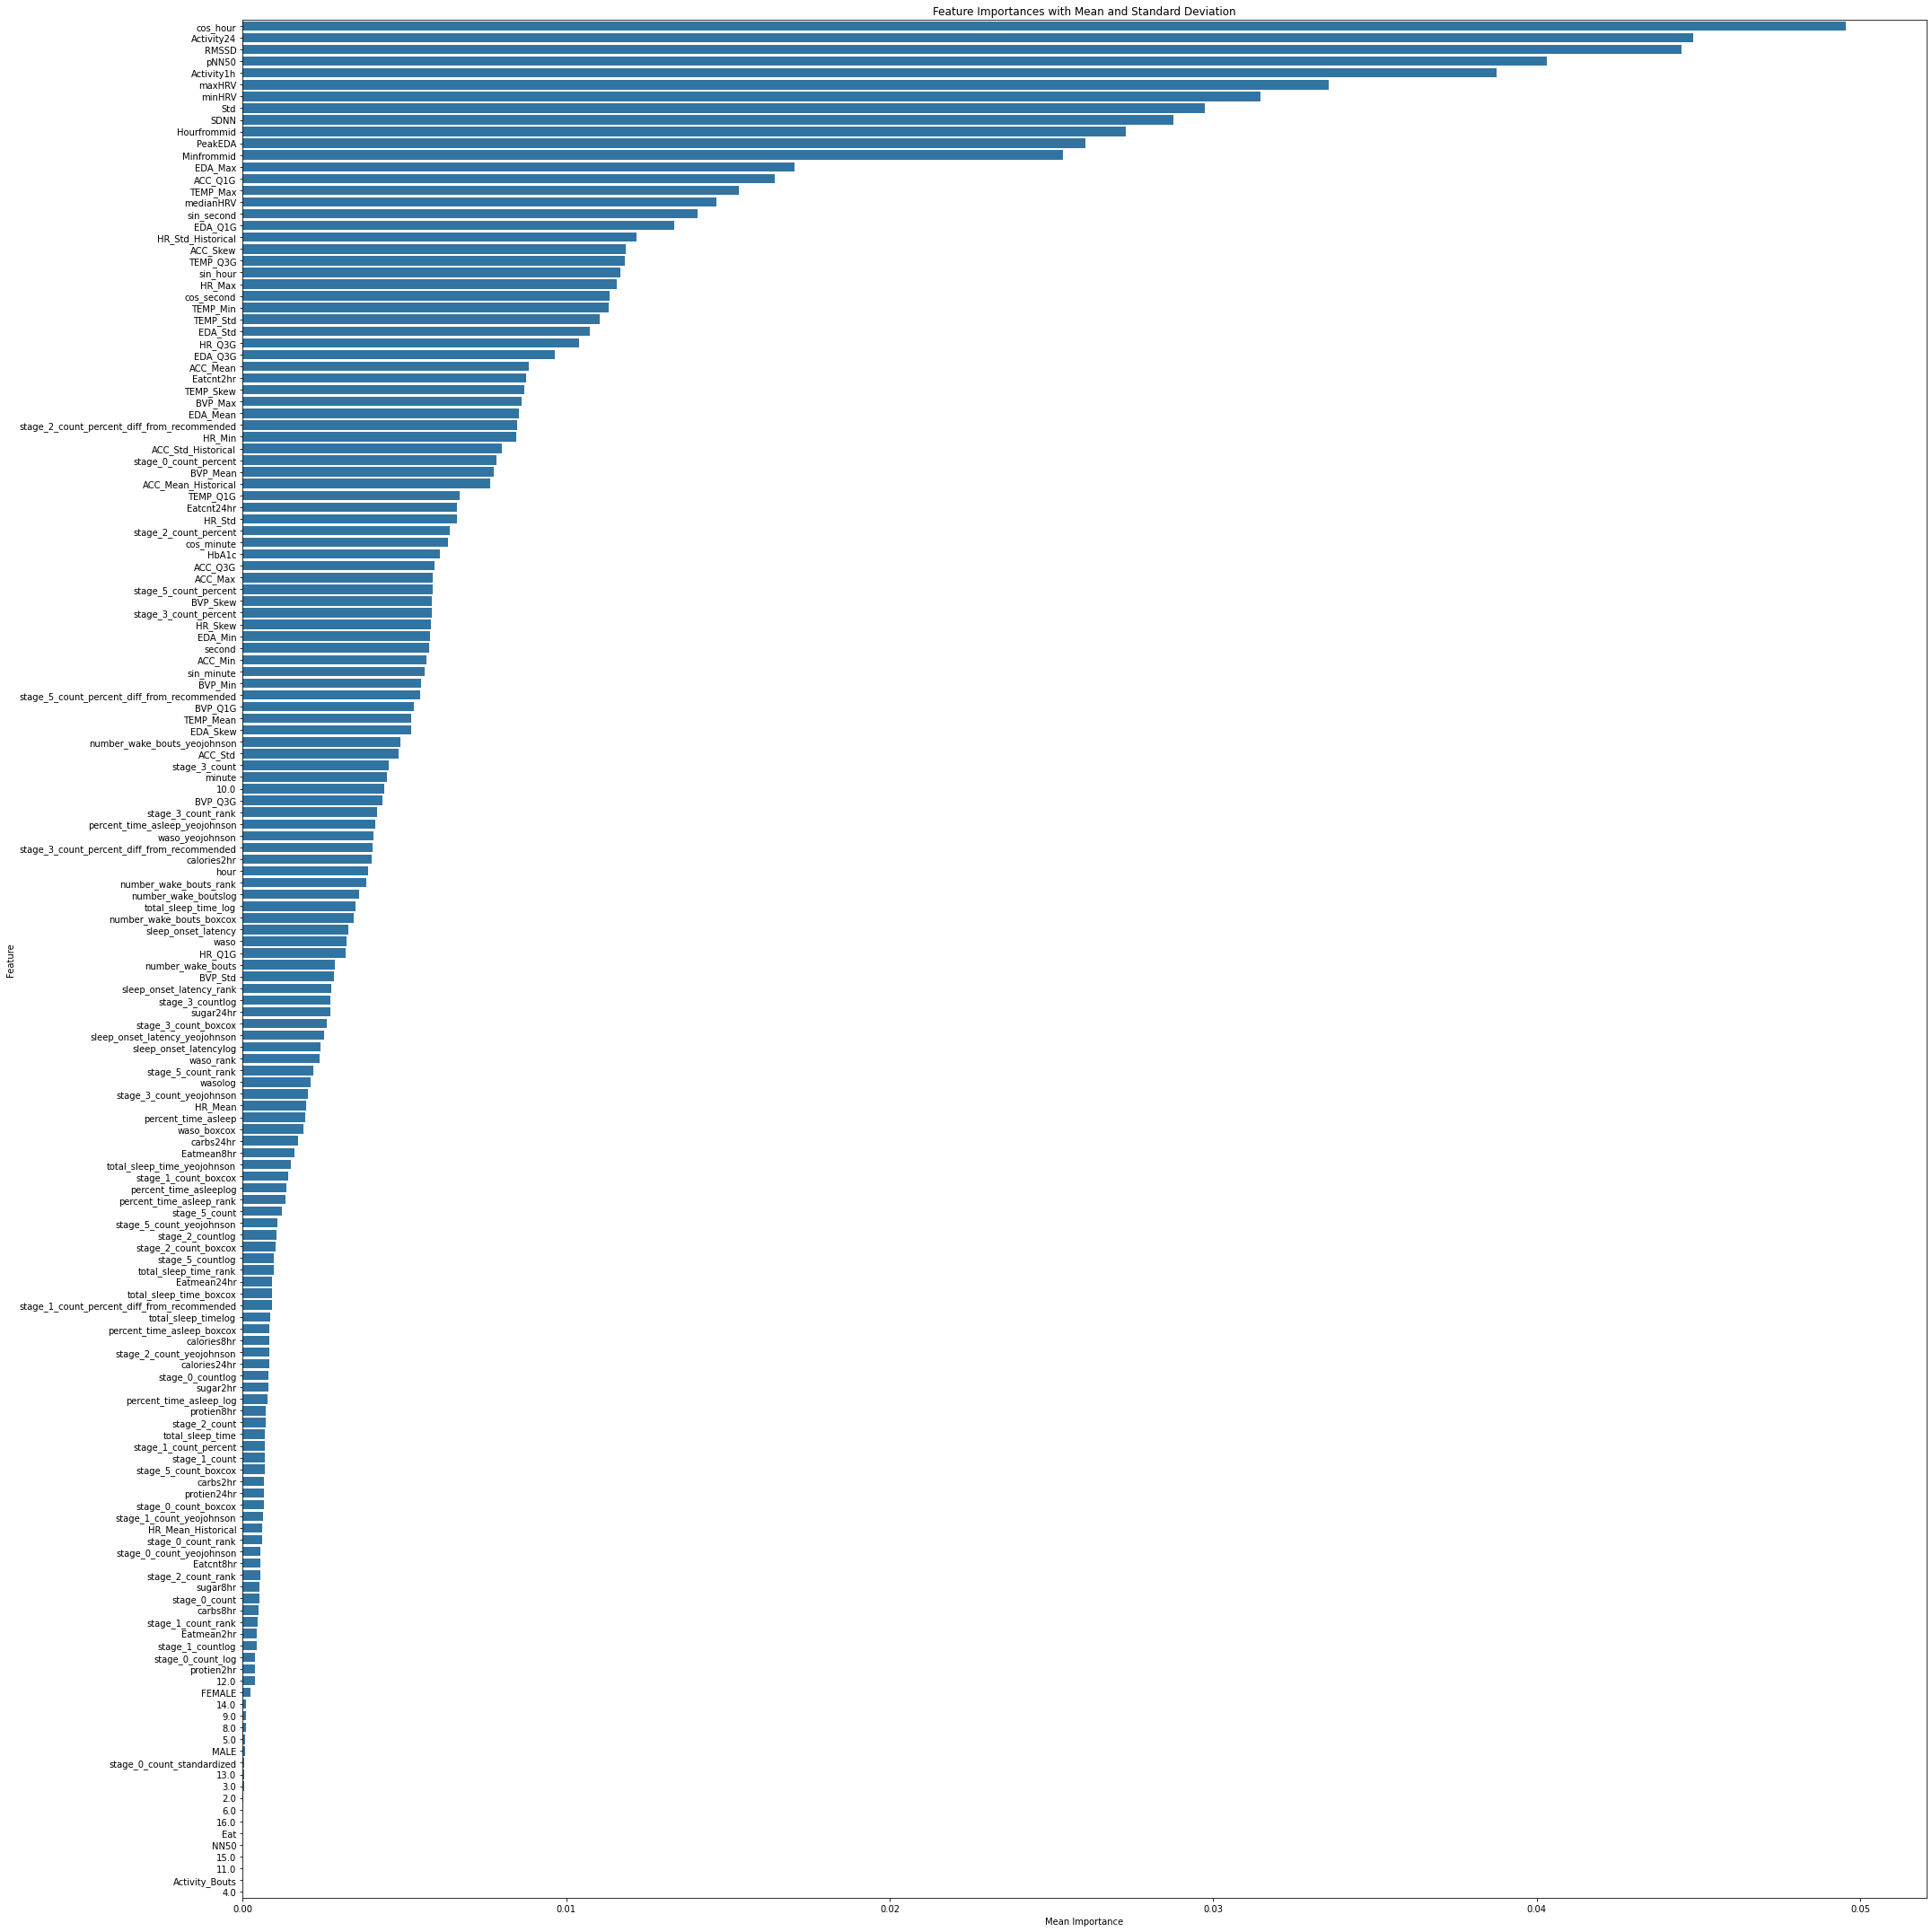

Generating SHAP summary plots: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

Feature importances and SHAP values plotted and saved.


In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from tqdm import tqdm


# Balancing the dataset
def balance_classes(df, target):
    class_counts = df[target].value_counts()
    min_class_count = class_counts.min()
    
    balanced_df = df.groupby(target).apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)
    return balanced_df

# Balance the entire dataset once
balanced_df = balance_classes(df_all, 'glucose_level')

# Define the features and target
X = balanced_df.drop(['glucose_level','IG','Mean'], axis=1)
y = balanced_df['glucose_level']


# Prepare to store results
importances_list = []
shap_values_list = []
acc_list = []


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)
rf =  DecisionTreeClassifier()
# Run the regression 10 times with tqdm progress bar
for i in tqdm(range(10), desc="Running Classifications"):
    # Split the data
    
    
    print('Training the model')
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc)
    print(f'Accuracy for run {i+1}: {acc}')
    
    
    
    print(' Storing feature importances')
    importances_list.append(rf.feature_importances_)
    
    print('Generating SHAP values')
    explainer = shap.Explainer(rf)
    shap_values = explainer.shap_values(X_test)
    shap_values_list.append(shap_values)
    
    print(' Plotting SHAP values')
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title(f'SHAP Summary Plot Run {i+1}')
    plt.savefig(f'shap_values/shap_claasification_summary_plot_run_{i+1}.png')
    plt.close()

# Calculate mean and std for feature importances
importances_array = np.array(importances_list)
importances_mean = np.mean(importances_array, axis=0)
importances_std = np.std(importances_array, axis=0)

# Create a DataFrame for feature importances
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean Importance': importances_mean,
    'Std Importance': importances_std
})
importances_df.to_csv('feature_importances_classification.csv')

# Plot mean feature importances with error bars
plt.figure(figsize=(30,30))
sns.barplot(x='Mean Importance', y='Feature', data=importances_df.sort_values(by='Mean Importance', ascending=False))
plt.title('Feature Importances with Mean and Standard Deviation')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importances_classification.svg')
plt.show()

# Club features into categories for analysis
for category, features in tqdm(feature_categories.items(), desc="Generating SHAP summary plots"):
    category_shap_values = np.sum([shap_values_list[i][:, [X.columns.get_loc(feature) for feature in features if feature in X.columns]] for i in range(10)], axis=0)
    
    shap.summary_plot(category_shap_values, X_test[features], show=False)
    plt.title(f'SHAP Summary Plot for {category}')
    plt.savefig(f'shap_values/shap_classification_summary_plot_{category}.svg')
    plt.close()

print("Feature importances and SHAP values plotted and saved.")

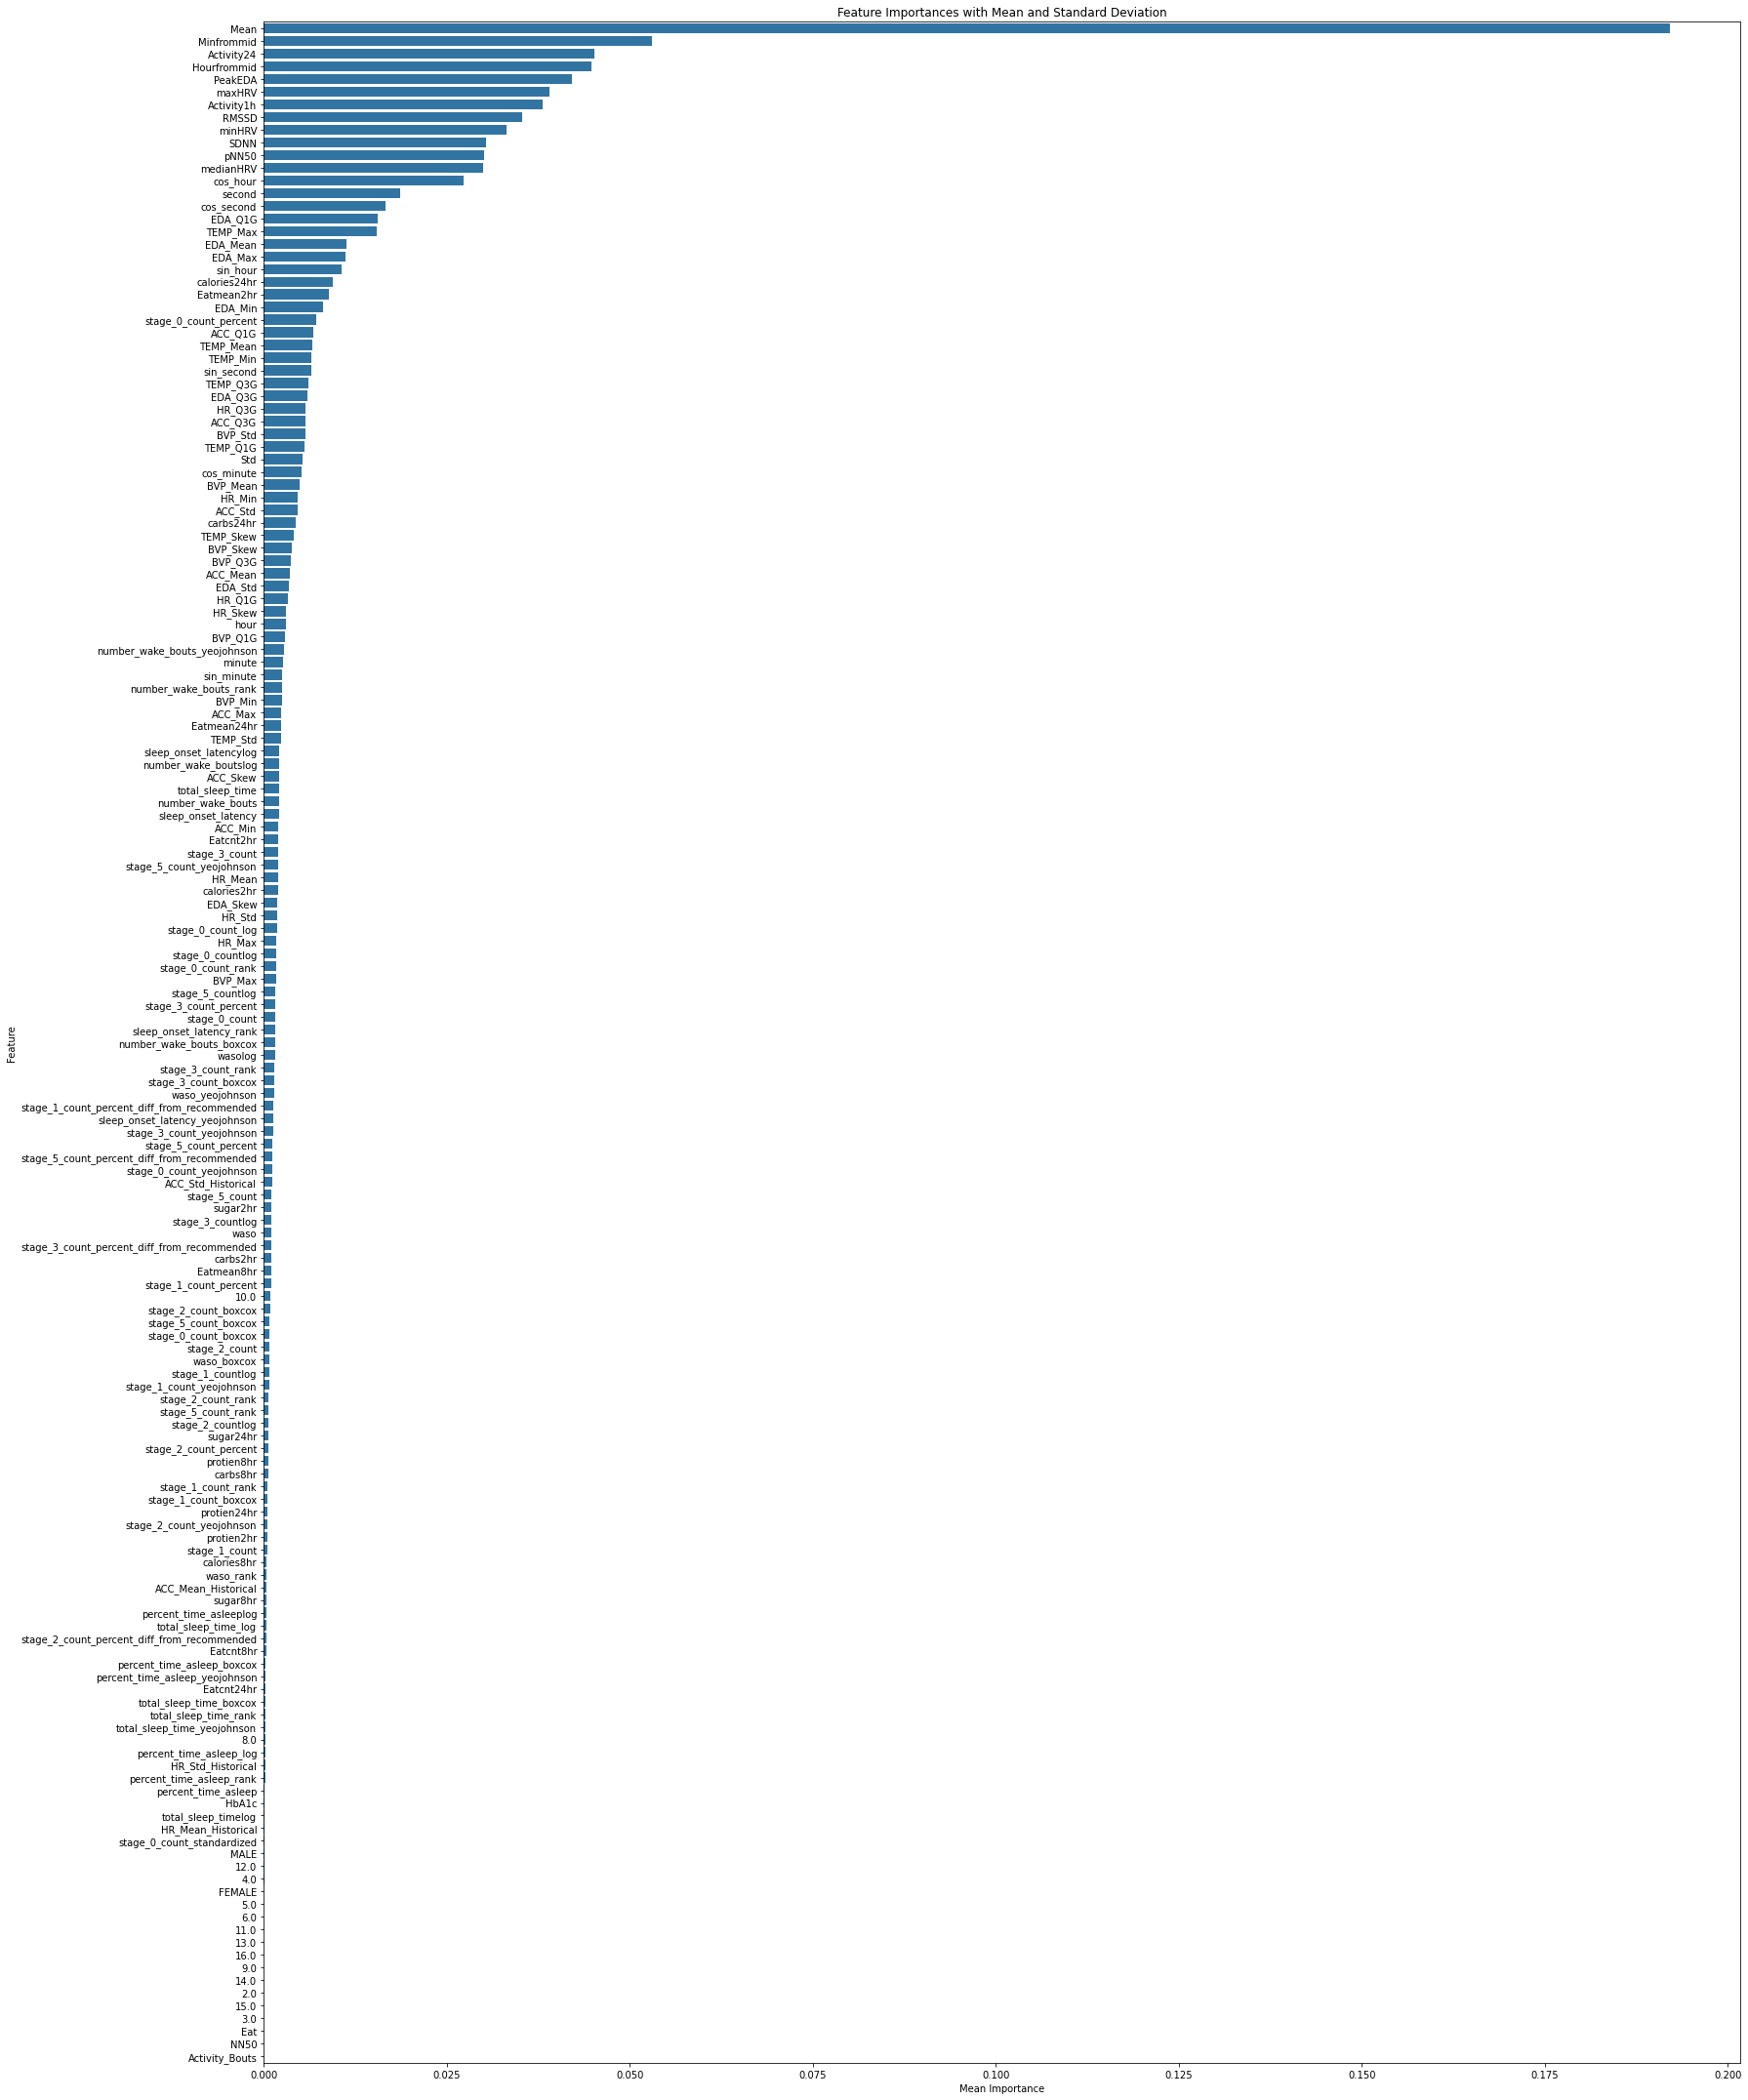

In [23]:
# Plot mean feature importances with error bars
plt.figure(figsize=(25, 30))
sns.barplot(x='Mean Importance', y='Feature', data=importances_df.sort_values(by='Mean Importance', ascending=False),  errorbar=('ci', 95))
plt.title('Feature Importances with Mean and Standard Deviation')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importances.svg')
plt.show()

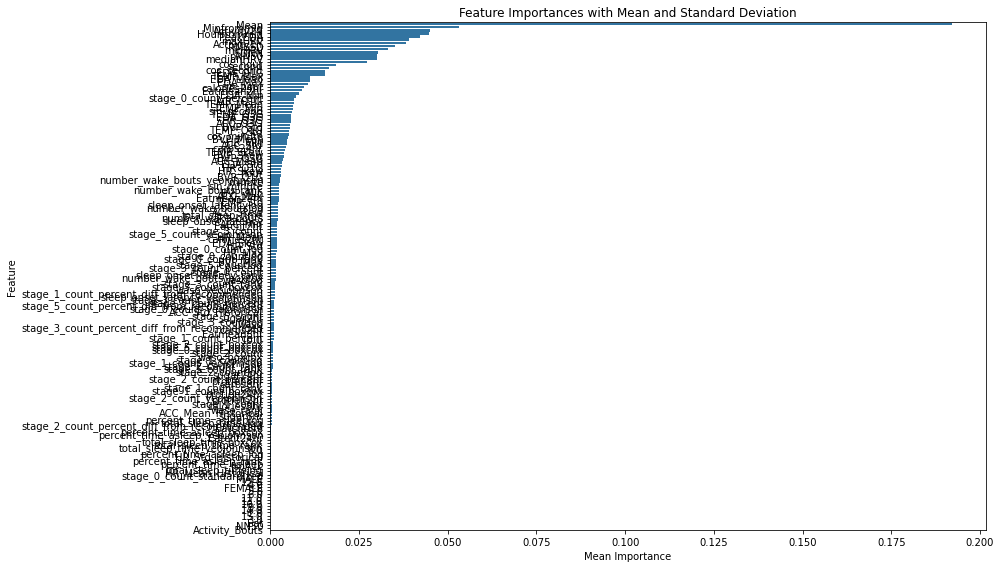

Generating SHAP summary plots: 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]

Feature importances and SHAP values plotted and saved.


In [14]:

# Create a DataFrame for feature importances
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean Importance': importances_mean,
    'Std Importance': importances_std
})



# Club features into categories for analysis
for category, features in tqdm(feature_categories.items(), desc="Generating SHAP summary plots"):
    category_shap_values = np.sum([shap_values_list[i][:, [X.columns.get_loc(feature) for feature in features if feature in X.columns]] for i in range(10)], axis=0)
    
    shap.summary_plot(category_shap_values, X_test[features], show=False)
    plt.title(f'SHAP Summary Plot for {category}')
    plt.savefig(f'shap_values/shap_summary_plot_{category}.svg')
    plt.close()

print("Feature importances and SHAP values plotted and saved.")

In [11]:
importances_df = pd.read_csv('feature_importances.csv')

In [12]:
importances_df.drop(['Unnamed: 0'],axis=1, inplace=True)


In [13]:
importances_df

,Feature,Mean Importance,Std Importance
0,HR_Mean,0.001182,0.000596
1,HR_Max,0.002271,0.000273
2,HR_Std,0.003053,0.000352
3,HR_Skew,0.002576,0.000261
4,HR_Q1G,0.002710,0.000608
...,...,...,...
155,cos_hour,0.030729,0.001534
156,sin_minute,0.002391,0.000864
157,cos_minute,0.002120,0.000139
158,sin_second,0.006597,0.000840


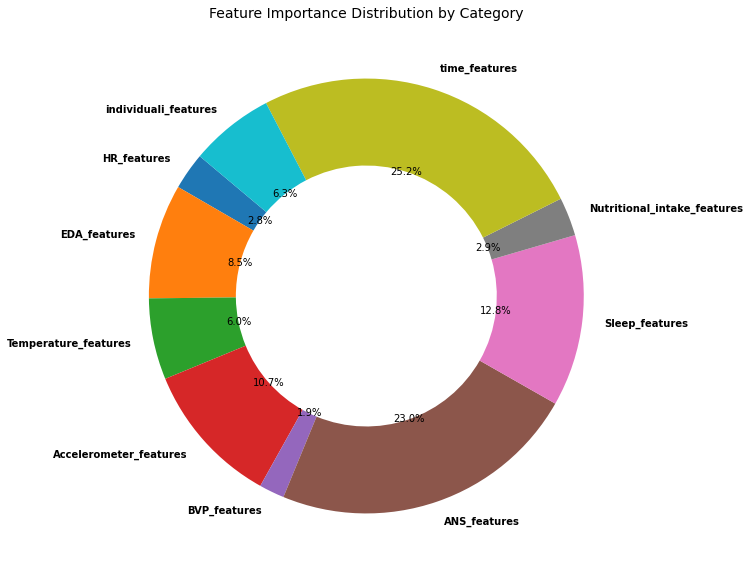

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the sum of feature importance for each category
category_importances = {category: np.sum(importances_df[importances_df['Feature'].isin(features)]['Mean Importance'])
                         for category, features in feature_categories.items()}

# Prepare data for the outer circle
outer_labels = list(category_importances.keys())
outer_sizes = list(category_importances.values())
outer_colors = plt.get_cmap('tab10', len(outer_labels)).colors

# Define the function to format the percentage values
def func(pct, allvalues):
    absolute = int(np.round(pct / 100. * np.sum(allvalues)))
    return f'{pct:.1f}%'

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))

# Create the outer pie chart
wedges, texts, pcts = ax.pie(outer_sizes, labels=outer_labels, colors=outer_colors, radius=1.0, wedgeprops=dict(width=0.4), autopct=lambda pct: func(pct, outer_sizes), startangle=140)
plt.setp(texts, size=10, weight="bold")

# Set the title
plt.title('Feature Importance Distribution by Category', fontsize=14)

# Save and show the plot
plt.savefig('feature_importance_pie_chart.svg')
plt.show()


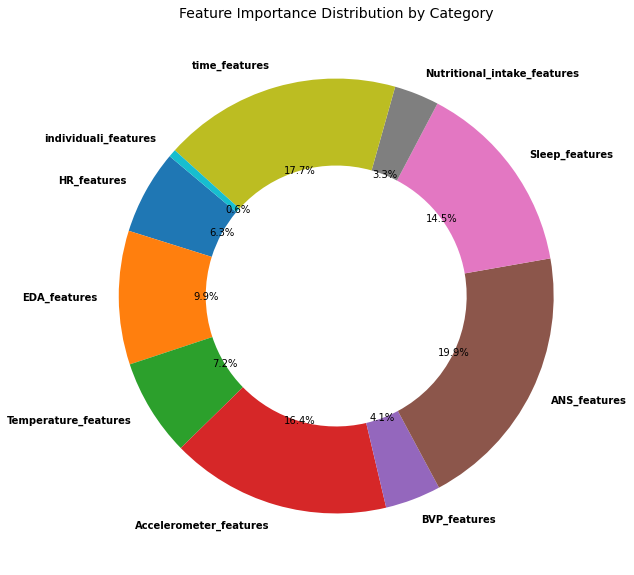

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the sum of feature importance for each category
category_importances = {category: np.sum(importances_df[importances_df['Feature'].isin(features)]['Mean Importance'])
                         for category, features in feature_categories.items()}

# Prepare data for the outer circle
outer_labels = list(category_importances.keys())
outer_sizes = list(category_importances.values())
outer_colors = plt.get_cmap('tab10', len(outer_labels)).colors

# Define the function to format the percentage values
def func(pct, allvalues):
    absolute = int(np.round(pct / 100. * np.sum(allvalues)))
    return f'{pct:.1f}%'

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))

# Create the outer pie chart
wedges, texts, pcts = ax.pie(outer_sizes, labels=outer_labels, colors=outer_colors, radius=1.0, wedgeprops=dict(width=0.4), autopct=lambda pct: func(pct, outer_sizes), startangle=140)
plt.setp(texts, size=10, weight="bold")

# Set the title
plt.title('Feature Importance Distribution by Category', fontsize=14)

# Save and show the plot
plt.savefig('feature_importance_pie_chart(classification).svg')
plt.show()
